### Import libraries

In [3]:
import tensorflow as tf #pip install tensorflow
import numpy as np #pip install numpy
import matplotlib.pyplot as plt #pip install mathplotlib
import os
import cv2  #pip ínstall cv2
from PIL import Image

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

In [563]:
#Avoid OOM Error by setting GPU memories Consumption Growth
gpus=tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu,True)

### Load image

In [117]:
data=tf.keras.utils.image_dataset_from_directory('Data')#building data pipeline



Found 802 files belonging to 2 classes.


In [86]:
data_iterator=data.as_numpy_iterator()#acess to pipeline


In [87]:
batch=data_iterator.next()#access to data pipeline itself


In [88]:
len(batch)

2

In [89]:
batch[0]

array([[[[224.       , 229.       , 232.       ],
         [224.11133  , 229.11133  , 232.11133  ],
         [225.18555  , 230.18555  , 233.18555  ],
         ...,
         [224.       , 234.       , 233.       ],
         [224.       , 234.       , 233.       ],
         [224.       , 234.       , 233.       ]],

        [[224.       , 229.       , 232.       ],
         [224.11133  , 229.11133  , 232.11133  ],
         [225.18555  , 230.18555  , 233.18555  ],
         ...,
         [224.       , 234.       , 233.       ],
         [224.       , 234.       , 233.       ],
         [224.       , 234.       , 233.       ]],

        [[224.       , 229.       , 232.       ],
         [224.11133  , 229.11133  , 232.11133  ],
         [225.18555  , 230.18555  , 233.18555  ],
         ...,
         [224.05327  , 234.05327  , 233.05327  ],
         [224.       , 234.       , 233.       ],
         [224.       , 234.       , 233.       ]],

        ...,

        [[191.72089  , 111.6044   ,  4

In [90]:
batch[0].shape #image review as numpy array

(32, 256, 256, 3)

In [91]:
#Class 0= desert, Class 1= Forest
batch[1]

array([0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0,
       1, 1, 0, 0, 0, 0, 1, 1, 0, 0])

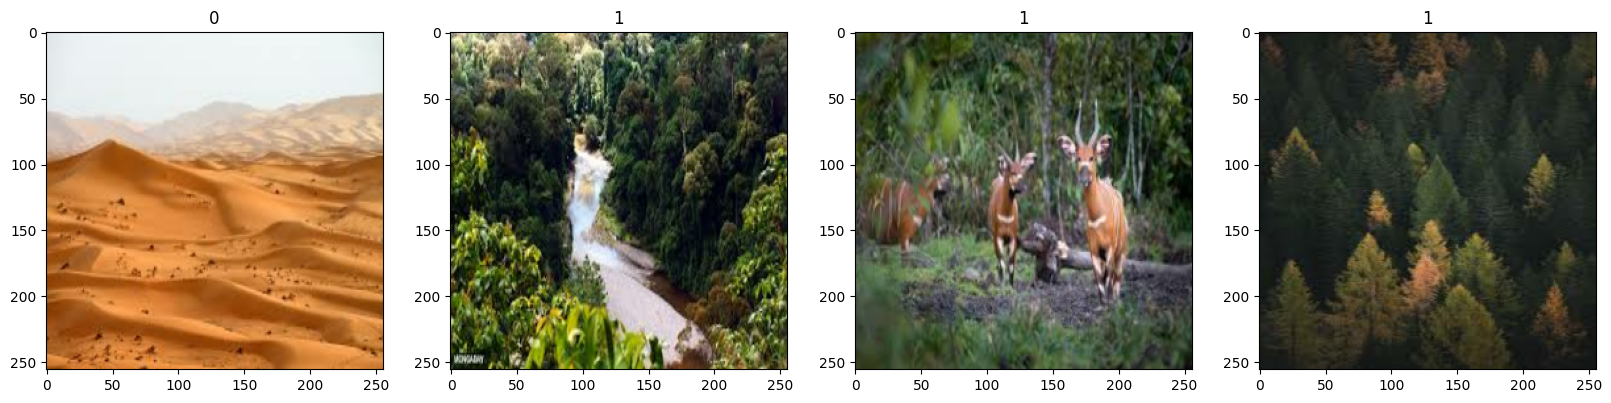

In [92]:
#class 0 is desert, class 1 is forest
fig, ax=plt.subplots(ncols=4, figsize=(20,20))
for idx ,img in enumerate(batch[0][:4]):
    ax[idx].imshow(img.astype(int))
    ax[idx].title.set_text(batch[1][idx])

In [93]:
scaled=batch[0]/255

In [94]:
scaled.max()

1.0

### Preprocessing of Data

Resize the data

Scale the data

In [119]:


data=data.map(lambda x, y: (x /255,y))


In [120]:
scale_iterator=data.as_numpy_iterator()


In [121]:
batch=scale_iterator.next()

In [122]:

first_image = batch[0]
print(np.min(first_image), np.max(first_image))

0.0 1.0


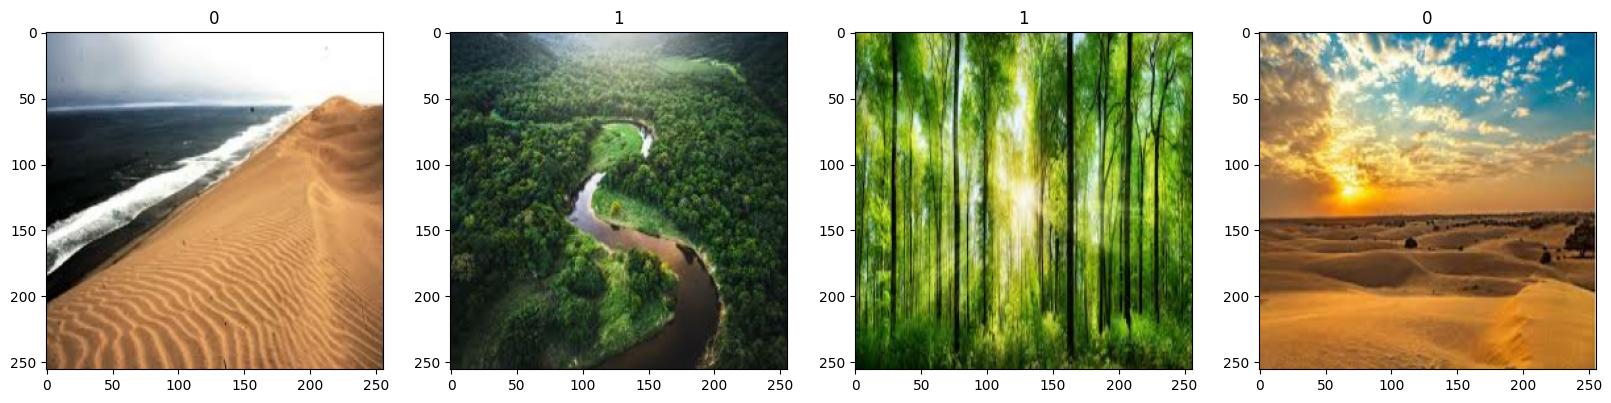

In [578]:
fig, ax=plt.subplots(ncols=4, figsize=(20,20))
for idx ,img in enumerate(batch[0][:4]):
    ax[idx].imshow(img)
    ax[idx].title.set_text(batch[1][idx])

Split Data

In [30]:
len(data)

26

In [66]:
batch_size = 32
img_height = 256
img_width = 256

In [69]:
train_size=int(len(data)*.7)
val_size=int(len(data)*.2)+2
test_size=int(len(data)*.1)-1

In [32]:
train_size

18

In [33]:
val_size

7

In [34]:
test_size

1

In [584]:
train_size+test_size+val_size

26

In [35]:
train=data.take(train_size)
val=data.skip(train_size).take(val_size)
test=data.skip(train_size+val_size).take(test_size)

In [36]:
len(test)

1

In [60]:
class_names = train_ds.class_names
print(class_names)

['Desert', 'Forest']


### Create the model

In [127]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Dense, Flatten, MaxPooling2D, Dropout

In [126]:
data_augmentation = keras.Sequential(
  [
    layers.RandomFlip("horizontal",
                      input_shape=(img_height,
                                  img_width,
                                  3)),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
  ]
)


In [128]:
model=keras.Sequential(
    
[
layers.Conv2D(16,(3,3), 1 ,activation='relu',input_shape=(256,256,3)),
layers.MaxPooling2D(),

layers.Conv2D(32,(3,3), 1 ,activation='relu'),
layers.MaxPooling2D(),

layers.Conv2D(16,(3,3), 1 ,activation='relu' ),
layers.MaxPooling2D(),

layers.Flatten(),

layers.Dropout(0.2),

layers.Dense(256,activation='relu'),
layers.Dense(1,activation='sigmoid')
]
)
  


### Compile file

In [129]:
#model.compile(optimizer='adam', loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), metrics=['accuracy'])
model.compile(optimizer='adam',
                loss = tf.keras.losses.binary_crossentropy,
                metrics=['accuracy'])

In [130]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_9 (Conv2D)           (None, 254, 254, 16)      448       
                                                                 
 max_pooling2d_9 (MaxPooling  (None, 127, 127, 16)     0         
 2D)                                                             
                                                                 
 conv2d_10 (Conv2D)          (None, 125, 125, 32)      4640      
                                                                 
 max_pooling2d_10 (MaxPoolin  (None, 62, 62, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_11 (Conv2D)          (None, 60, 60, 16)        4624      
                                                                 
 max_pooling2d_11 (MaxPoolin  (None, 30, 30, 16)      

### Train

In [131]:
#train the model for 30 epochs
# #model.fit(train_images,train_labels, epochs=30)   

logdir='log'

In [132]:
tensorboard_callback=tf.keras.callbacks.TensorBoard(log_dir=logdir)

In [133]:
hist=model.fit(train,epochs=10, validation_data= val, callbacks=[tensorboard_callback])


Epoch 1/10
18/18 [==============================] - 28s 1s/step - loss: 0.5866 - accuracy: 0.7205 - val_loss: 0.0912 - val_accuracy: 0.9643
Epoch 2/10
18/18 [==============================] - 24s 1s/step - loss: 0.0513 - accuracy: 0.9861 - val_loss: 0.0184 - val_accuracy: 0.9955
Epoch 3/10
18/18 [==============================] - 24s 1s/step - loss: 0.1172 - accuracy: 0.9635 - val_loss: 0.0246 - val_accuracy: 1.0000
Epoch 4/10
18/18 [==============================] - 24s 1s/step - loss: 0.0397 - accuracy: 0.9878 - val_loss: 0.0223 - val_accuracy: 0.9911
Epoch 5/10
18/18 [==============================] - 24s 1s/step - loss: 0.0239 - accuracy: 0.9931 - val_loss: 0.0300 - val_accuracy: 0.9866
Epoch 6/10
18/18 [==============================] - 24s 1s/step - loss: 0.0186 - accuracy: 0.9931 - val_loss: 0.0174 - val_accuracy: 0.9955
Epoch 7/10
18/18 [==============================] - 24s 1s/step - loss: 0.0352 - accuracy: 0.9896 - val_loss: 0.0587 - val_accuracy: 0.9777
Epoch 8/10
18/18 [==

In [597]:
hist.history

{'loss': [0.019641583785414696,
  0.026271536946296692,
  0.061392419040203094,
  0.025935819372534752,
  0.012186441570520401,
  0.010161752812564373,
  0.01651134341955185,
  0.008039800450205803,
  0.005121046677231789,
  0.002677627606317401,
  0.001131261233240366,
  0.0013260450214147568,
  0.000666289881337434,
  0.0007664977456443012,
  0.0009337228839285672,
  0.001424832153134048,
  0.01004368532449007,
  0.09945586323738098,
  0.019046209752559662,
  0.037688713520765305,
  0.031046006828546524,
  0.007092470768839121,
  0.004043653141707182,
  0.0022051564883440733,
  0.0009272195748053491,
  0.0003216125478502363,
  0.0004150377353653312,
  0.0003707015421241522,
  0.0002487722085788846,
  0.00019488355610519648],
 'accuracy': [0.9947916865348816,
  0.9895833134651184,
  0.9739583134651184,
  0.9878472089767456,
  0.9930555820465088,
  0.9947916865348816,
  0.9913194179534912,
  0.9982638955116272,
  0.9982638955116272,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  0.

### Plot Performance

AttributeError: 'Text' object has no property 'frontsize'

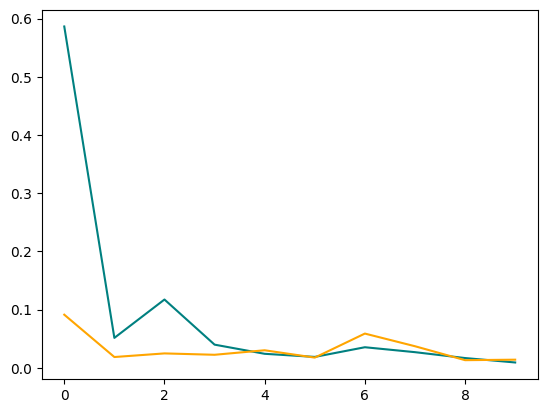

In [134]:
fig=plt.figure()
plt.plot(hist.history['loss'],color='teal',label='loss')
plt.plot(hist.history['val_loss'],color='orange',label='val_loss')
fig.suptitle('Loss',frontsize=10)
plt.legend(loc="upper left")
plt.show()

AttributeError: 'Text' object has no property 'frontsize'

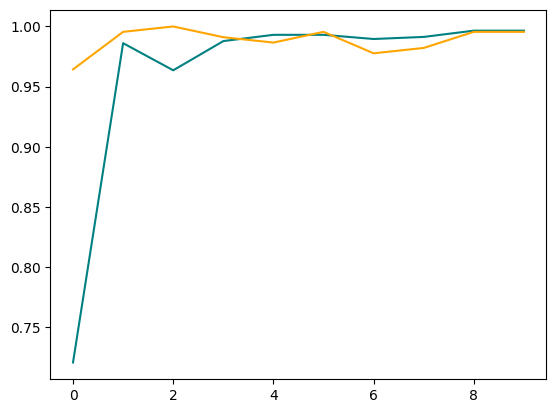

In [135]:
fig=plt.figure()
plt.plot(hist.history['accuracy'],color='teal',label='accuracy')
plt.plot(hist.history['val_accuracy'],color='orange',label='val_accuracy')
fig.suptitle('Loss',frontsize=10)
plt.legend(loc="upper left")
plt.show()

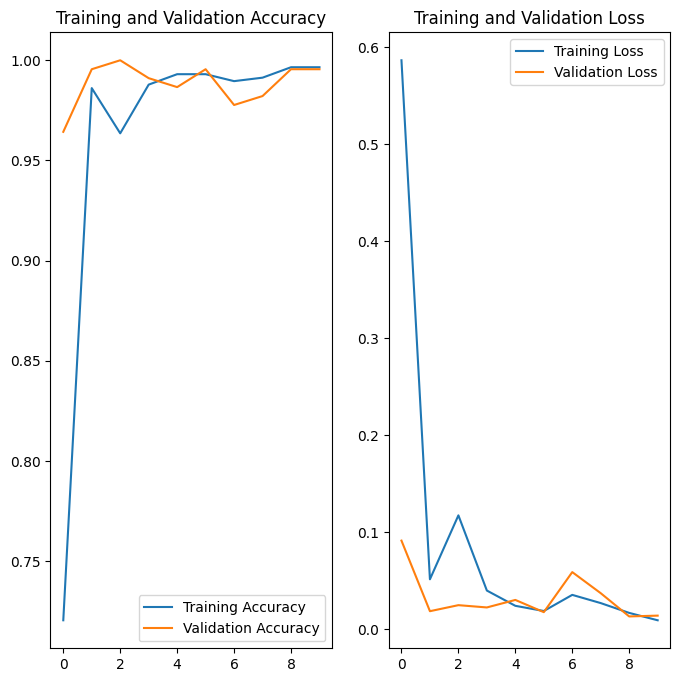

In [136]:
acc = hist.history['accuracy']
val_acc = hist.history['val_accuracy']

loss = hist.history['loss']
val_loss = hist.history['val_loss']

epochs_range = range(10)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

### evaluate

In [137]:
#test_loss, test_acc = model.evaluate(test_images, test_labels, verbose = 2)
#print("accuracy", test_acc)
#print("loss", test_loss)
from tensorflow.keras.metrics import Precision, Recall, BinaryAccuracy


In [140]:
pre=Precision()
re=Recall()
acc=BinaryAccuracy()

In [138]:
len(test)

1

In [141]:
for batch in test.as_numpy_iterator():
    X,y=batch
    yhat=model.predict(X)
    pre.update_state(y, yhat)
    re.update_state(y, yhat)
    acc.update_state(y, yhat)



1/1 [==============================] - 0s 83ms/step


In [ ]:
print (f'Precision:{pre.result().numpy()}, Recall:{re.result().numpy()}, Accuracy:{acc.result().numpy()}')

Precision:1.0, Recall:1.0, Accuracy:1.0


### Test

In [142]:
import tensorflow as tf
from tensorflow.keras.applications.resnet50 import preprocess_input, decode_predictions
from tensorflow.keras.preprocessing import image
# Helper libraries
import numpy as np
import matplotlib.pyplot as pl

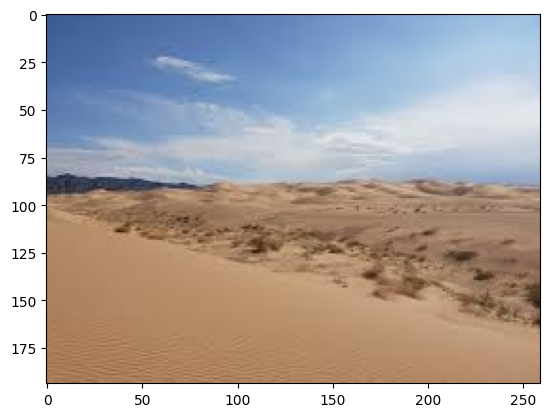

In [143]:
path=r"C:\Users\hophu\Desktop\Data\Desert\desert.4.jpg"
img=cv2.imread(path)
plt.imshow(cv2.cvtColor(img,cv2.COLOR_BGR2RGB))
plt.show()

In [144]:
resize=tf.image.resize(img,(256,256))


<function matplotlib.pyplot.show(close=None, block=None)>

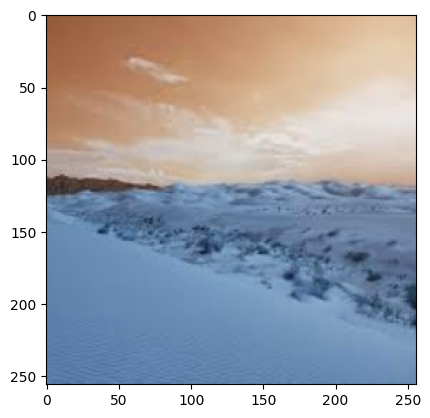

In [145]:
plt.imshow (resize.numpy().astype(int))
plt.show

In [146]:
resize.shape

TensorShape([256, 256, 3])

In [147]:
np.expand_dims(resize, 0)

array([[[[146.00586 ,  89.00586 ,  57.00586 ],
         [147.      ,  90.      ,  58.      ],
         [147.      ,  90.      ,  58.      ],
         ...,
         [223.0293  , 186.14648 , 158.      ],
         [223.      , 186.      , 158.      ],
         [222.00586 , 185.00586 , 157.00586 ]],

        [[146.63885 ,  89.63885 ,  57.638847],
         [147.      ,  90.      ,  58.      ],
         [147.      ,  90.      ,  58.      ],
         ...,
         [223.04794 , 186.16513 , 158.01865 ],
         [223.      , 186.      , 158.      ],
         [222.63885 , 185.63885 , 157.63885 ]],

        [[147.      ,  90.      ,  58.      ],
         [147.      ,  90.      ,  58.      ],
         [147.01157 ,  90.01156 ,  58.01156 ],
         ...,
         [223.44156 , 186.55875 , 158.41226 ],
         [223.39453 , 186.39453 , 158.39453 ],
         [223.00232 , 186.00232 , 158.00232 ]],

        ...,

        [[ 88.98099 , 123.98099 , 167.98099 ],
         [ 90.41259 , 125.41259 , 169.4126  ]

In [149]:
probably=model.predict(np.expand_dims(resize/255,0))
print(probably)

1/1 [==============================] - 0s 46ms/step
[[0.9825186]]


In [150]:
if probably < 0.5 :
    print(f'predict is desert')
else:
    print(f'predict is forest')

predict is forest


### predict all random image